In [1]:
import math 
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import random

In [2]:
# fonksiyon tanımlandığında verilen değerlerin fonksiyondaki 
# karşılıkları ve türev değerleri incelenir

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

In [4]:
f(3.0)

20.0

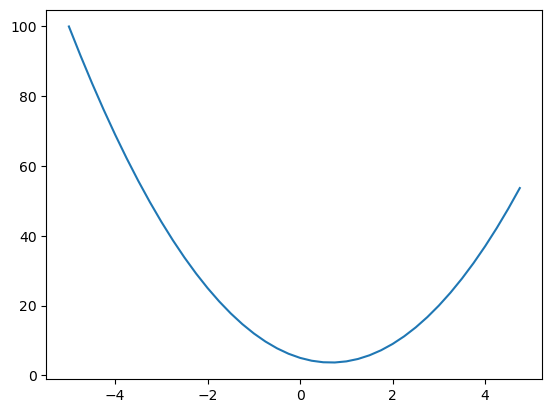

In [5]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)
plt.show()

In [6]:
# türevi bilgisayara nasıl hesaplatırız

In [7]:
h = 0.00000001
x = 3.0
(f(x+h) - f(x))/h

14.00000009255109

In [8]:
# biraz daha karışık haline bakalım

In [9]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [10]:
 # sonun a,b ve c noktalarına karşı türevi

In [11]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print("d1", d1)
print("d2", d2)
print("slope", (d2-d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [12]:
# oluşturacağımız Value nesnesi ile ileri yayılımda işlemlerin ilerlemesini 
# bilgisini ve gradient değerlerini tutmamız kolaylaşır, anlamamıza yardımcı olur

In [13]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out
        
    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

        


In [14]:
a = Value(4.0)
b = Value(2.0)
a/b

Value(data=2.0)

In [15]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')

L = d * f; L.label = 'L'  
L

Value(data=-8.0)

In [16]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [17]:
d._op

'+'

In [18]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot
        

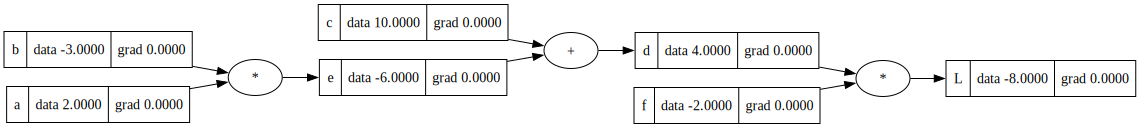

In [19]:
draw_dot(L)

In [20]:
# bu fonksiyonla istenilen değerin türevi kontrol edilebilir

In [21]:
def lol():
    
    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')

    L = d * f; L.label = 'L'  
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    c.data += h
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')

    L = d * f; L.label = 'L'  
    L2 = L.data

    print((L2 - L1)/h)

lol()

-1.9999999999988916


In [22]:
# ama biz şimdilik grad değerlerini manuel hesaplayıp gireceğiz

h = 0.0001

L.grad = 1.0

L = f*d
dl/df = (((f + h)*d) - (f*d)) / h = (f*d + h*d + - f*d) / h = (h*d) / h = d

dl/df = 4.0

dl/dd = -2.0

zincir kuralı

dl/dc = (dl/dd)*(dd/dc) 

dd/dc = (((d + h) + e) - (d + e)) / h = 1.0

dd/dc = 1.0

dl/dc = (-2.0)*(1.0) = -2.0


dl/de = -2.0

dl/da = (dl/dd)*(dd/de)*(de/da) 

de/da = -3.0

dl/da = (-2.0)*(1.0)*(-3.0) = 6



dl/db = -4.0


In [23]:
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0
c.grad = -2.0
e.grad = -2.0
a.grad = 6
b.grad = -4.0

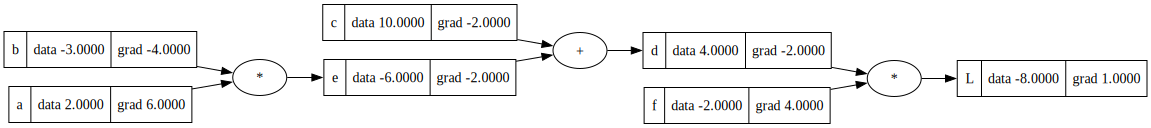

In [24]:
draw_dot(L)

In [25]:
# tanh aktivasyon fonksiyonu

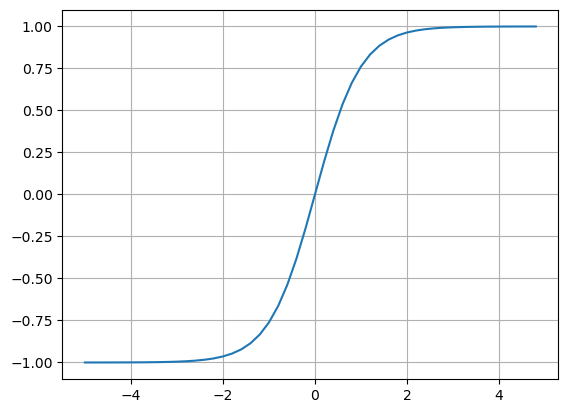

In [26]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid(True)
plt.show()

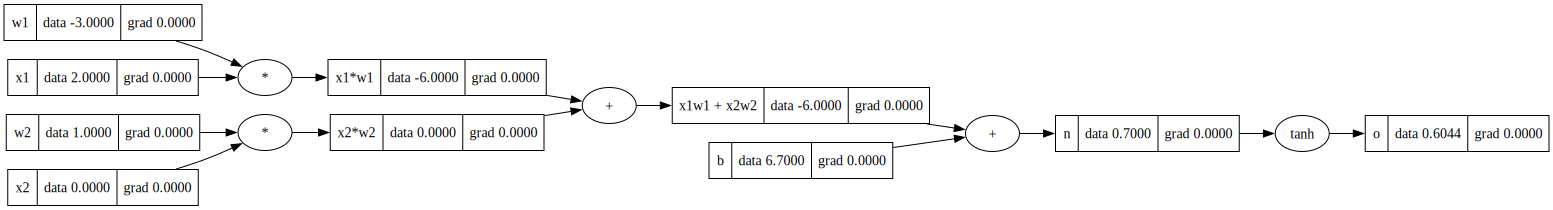

In [27]:
# girdiler x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# ağırlıklar w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# nöron bias
b = Value(6.7, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
draw_dot(o)

In [28]:
# tekrar manuel olarak grad değerlerini girelim

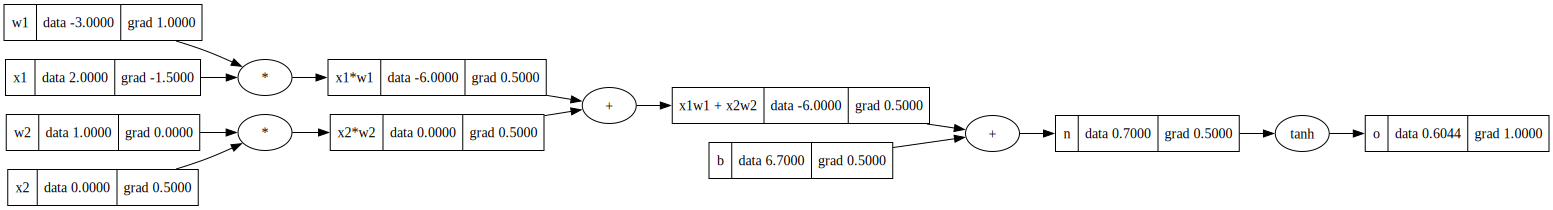

In [29]:
o.grad = 1.0
n.grad = 0.5
b.grad = 0.5
x1w1x2w2.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5
w2.grad = x2.data*x2w2.grad
x2.grad = w2.data*x2w2.grad
x1.grad = w1.data*x1w1.grad
w1.grad = x1.data*x1w1.grad

draw_dot(o)

In [30]:
# şimdi tanımladığımız _backward ile sondan başa doğru çalıştıralım

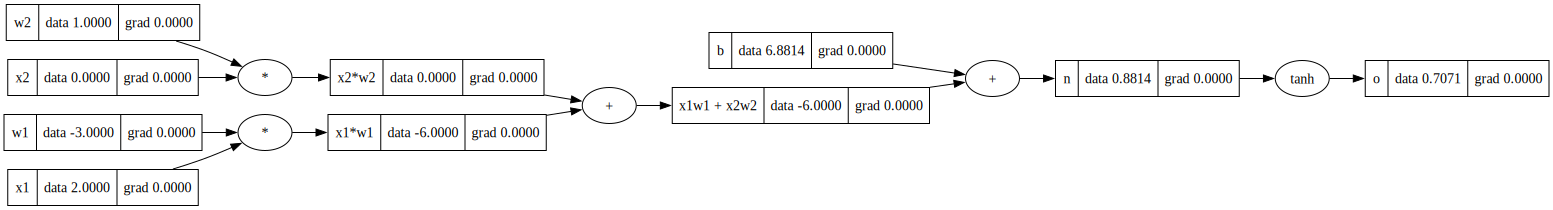

In [31]:
# girdiler x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# ağırlıklar w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# nöron bias
b = Value(6.88137358, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
draw_dot(o)

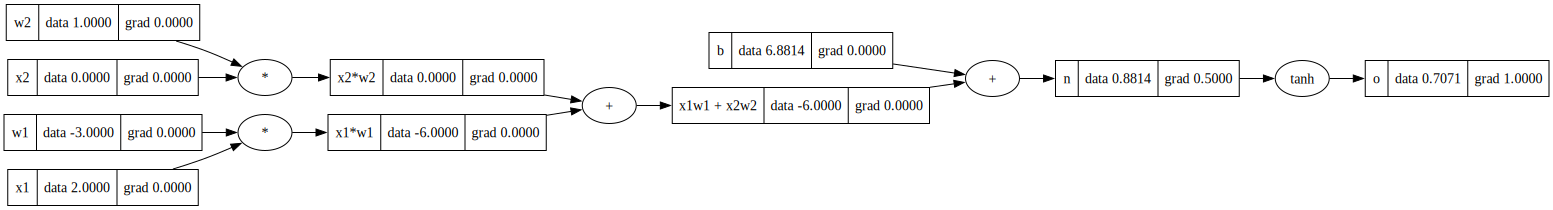

In [32]:
o.grad = 1.0
o._backward()
draw_dot(o)

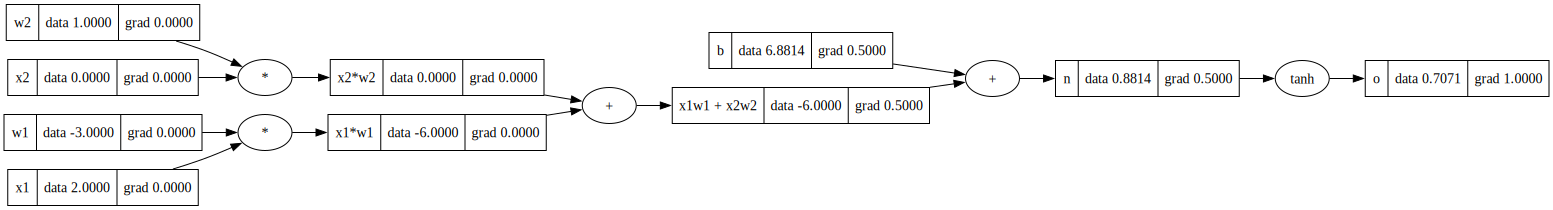

In [33]:
n._backward()
draw_dot(o)

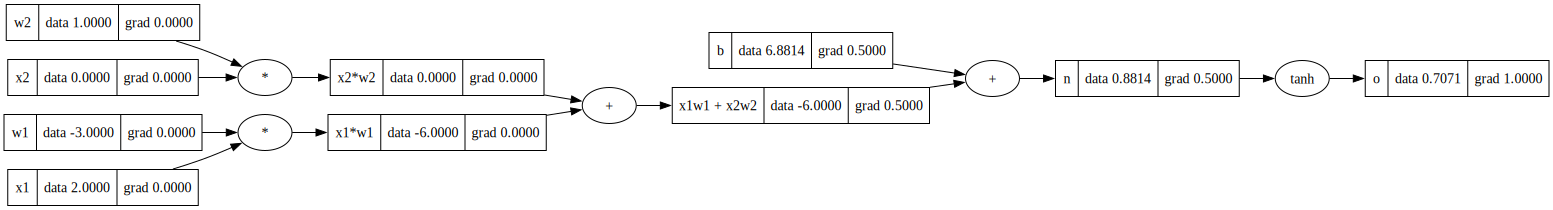

In [34]:
# yaprak düğümlerde backward çalıştırmak grad değerlerinde değişiklik yapmaz
b._backward()
draw_dot(o)

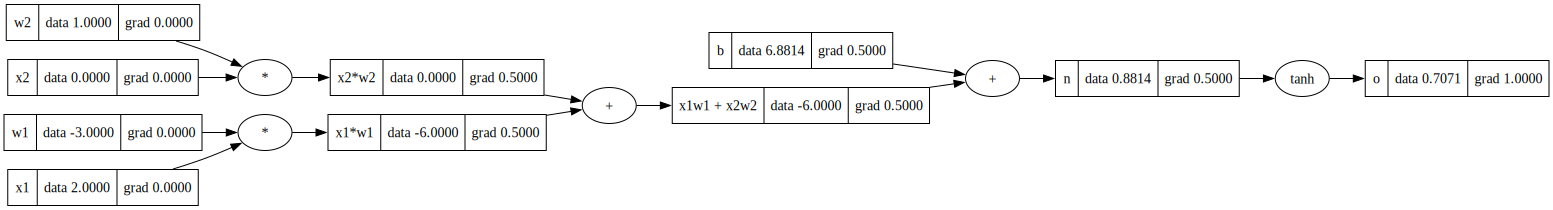

In [35]:
x1w1x2w2._backward()
draw_dot(o)

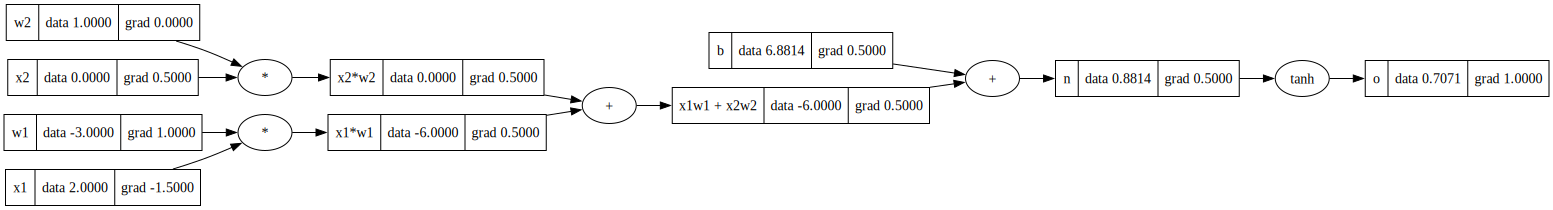

In [36]:
x1w1._backward()
x2w2._backward()
draw_dot(o)

In [37]:
# biz manuel çalıştırmak yerine topoloji ile sondan başa doğru tüm düğümlerde çalışmasını sağlayalım

In [38]:
# girdiler x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# ağırlıklar w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# nöron bias
b = Value(6.88137358, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

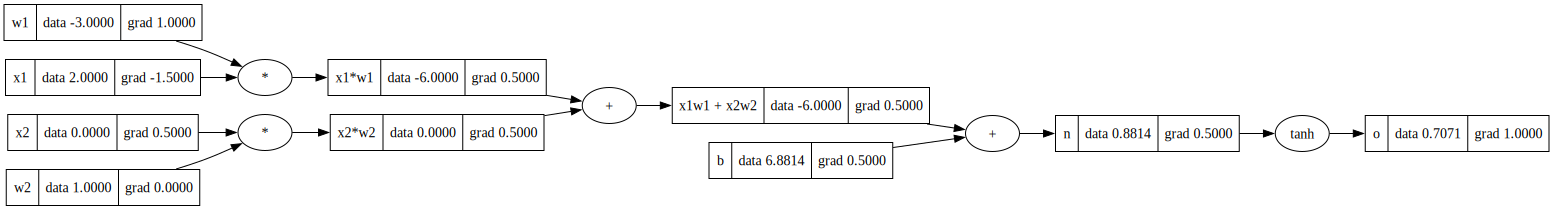

In [39]:
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

for node in reversed(topo):
    node._backward()

draw_dot(o)

In [40]:
# bunu Value classında tanımlarsak da böyle kullanabiliriz

In [41]:
# tekrar gradları sıfırlayalım 
# girdiler x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# ağırlıklar w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# nöron bias
b = Value(6.88137358, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

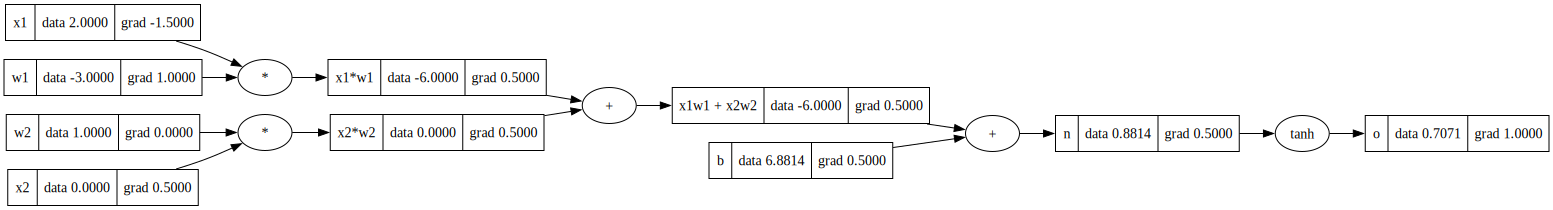

In [42]:
o.backward()
draw_dot(o)

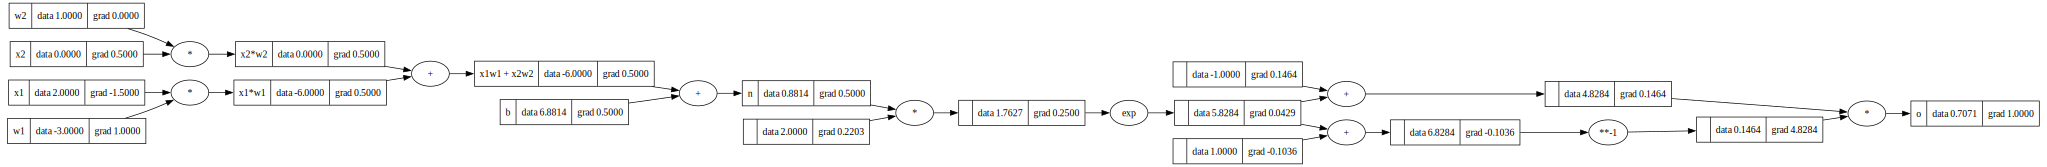

In [43]:
# tekrar gradları sıfırlayalım 
# girdiler x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# ağırlıklar w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# nöron bias
b = Value(6.88137358, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
#-----
e = (2*n).exp()
o = (e -1) / (e + 1)
o.label = 'o'
o.backward()
draw_dot(o)

In [44]:
import torch

In [45]:
# nöron ve nöronlardan oluşan bir katman kodlamaya başlayalım

In [46]:
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.29375243159763953)

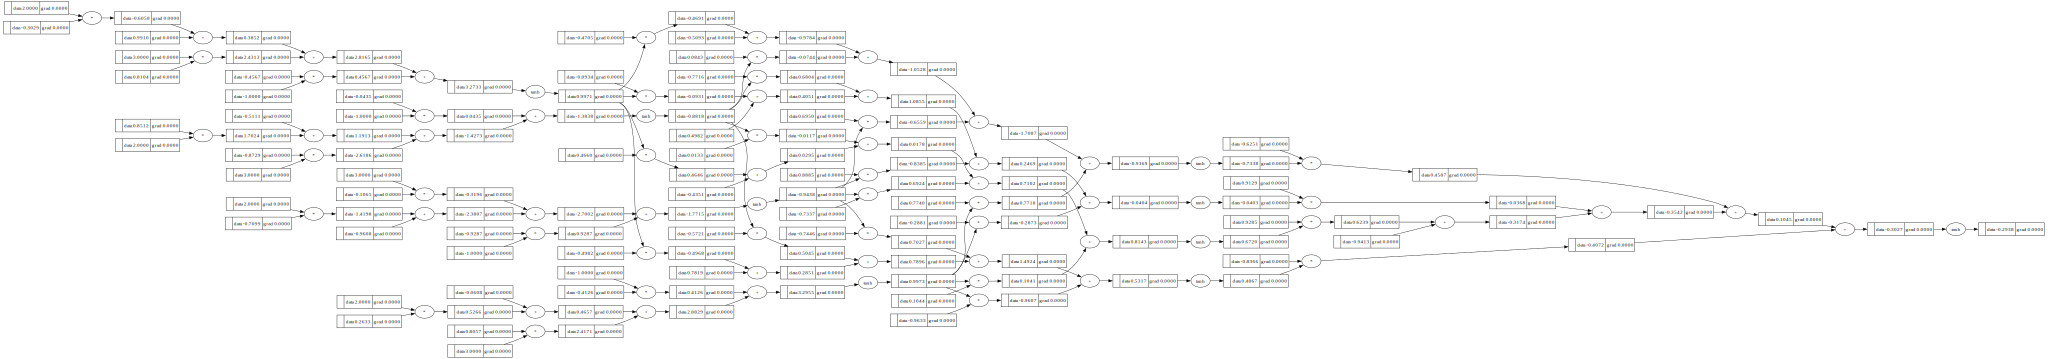

In [47]:
draw_dot(n(x))

In [48]:
# kayıp fonksiyonu

In [51]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # ulaşmak istediğimz sonuclar
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.29375243159763953),
 Value(data=-0.9638465252397317),
 Value(data=-0.46162789750895344),
 Value(data=-0.29945008228023046)]